<a href="https://colab.research.google.com/github/Tyanakai/medical_paper_classification/blob/main/medical_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>医学論文の自動仕分けチャレンジ データ概観</h1>

# 1. はじめに

本ノートブックは、SIGNATE上で開催された、文章分類コンペティション[医学論文の自動仕分けチャレンジ](https://signate.jp/competitions/471)で用いられた訓練データ`train.csv`、及び検証データ`test.csv`を概観し、分析するものです。又、各データにおける文字化けや欠損値の処理を行います。  
尚、colabratory上での実行を想定しています。


# 2. 事前に完了していること

データをGoogleDriveにアップロード(`train.csv`,`test.csv`)

# 3. コンペティションの概要

コンペティションのタスクは、論文のタイトル（`title`）および抄録(`abstract`)のテキストデータを用いて、その論文が「診断精度研究」と呼ばれる学術分野に該当する文献か否か(`judgement = 0 or 1`)を判定するものとなっています。


# 4. 実行フロー

1. GoogleDriveのマウント
2. ライブラリのインポート
3. データのロード、概観、前処理
4. データ分析
5. データ保存


### 処理ごとの目的と入出力一覧

|項番|目的|入力|出力|
|:-:|:--|:--|:--|
|1|GoogleDriveのマウント|−|−|
|2|ライブラリのインポート|−|−|
|3|データのロード、概観、前処理|ファイルパス(.csv)|pandas.DataFrame|
|4|各column毎に分布等を調べる|pandas.DataFrame|データの統計|
|5|保存|pandas.DataFrame||


# 5. 実行

## 5.1 Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5.2 ライブラリのインポート
必要となるライブラリをインポートします。


In [ ]:
from collections import Counter
import os
import re
from typing import List

from matplotlib import pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

## 5.3 データロード、概観、前処理

### 5.3.1 データのロード
pathを設定しデータをロードします。

In [ ]:
DRIVE = "/content/drive/MyDrive/signate/medical_paper"
INPUT = os.path.join(DRIVE, "input")
OUTPUT = os.path.join(DRIVE, "output")

train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))

### 5.3.2 データ概観
train_df, test_df 共に、データ重複の可能性は低く、"abstract"に欠損値が見られます。

In [ ]:
train_df.shape, test_df.shape

((27145, 4), (40834, 3))

In [ ]:
train_df.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [ ]:
test_df.head()

,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


In [ ]:
train_df.info()
train_df.describe(include="O")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27145 entries, 0 to 27144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27145 non-null  int64 
 1   title      27145 non-null  object
 2   abstract   22755 non-null  object
 3   judgement  27145 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 848.4+ KB


,title,abstract
count,27145,22755
unique,27145,22755
top,Iodine -131 metaiodobenzylguanidine is an effe...,The source of a fever of unknown origin (FUO) ...
freq,1,1


In [ ]:
test_df.info()
test_df.describe(include="O")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40834 entries, 0 to 40833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        40834 non-null  int64 
 1   title     40834 non-null  object
 2   abstract  34288 non-null  object
dtypes: int64(1), object(2)
memory usage: 957.2+ KB


,title,abstract
count,40834,34288
unique,40834,34288
top,Reduced hippocampal metabolism in MCI and AD: ...,The genotype (M/M M/V or V/V) at polymorphic...
freq,1,1


### 5.3.3 データ前処理
欠損値は空文字で補完し、コンペティションのフォーラム上で公開された関数を用いて文字化けの処理を行います。


In [ ]:
def preprocess(sentence):
    sentence = replace_double_quotation(sentence)
    sentence = replace_garbled_text(sentence)
    return sentence

def replace_garbled_text(sentence):
    garbled_char_table = {
        'Â©': '©', '–': '-', '‐': '-', 'ﾂ｣': '£', 'ﾂｩ': '©', 'ﾂｫ': '«', 
        'ﾂｮ': '®', 'ﾂｰ': '°', 'ﾂｱ': '±', 'ﾂｲ': '²', 'ﾂｳ': '³', 'ﾂｴ': '´', 
        'ﾂｵ': 'µ', 'ﾂｷ': '·', 'ﾂｸ': '¸', 'ﾂｹ': '¹', 'ﾂｼ': '¼', 'ﾂｽ': '½', 
        'ﾂｾ': '¾', 'ﾂｿ': '¿', 'ﾂ': '', 'ﾃｷ': '÷', 'ﾃｸ': 'ø', 'ﾃ': 'a', 
        'ﾃ｡': 'a', 'ﾃ｢': 'a', 'ﾃ｣': 'a', 'ﾃ､': 'a', 'ﾃ･': 'a', 'ﾃｦ': 'ae', 
        'ﾃｧ': 'c', 'ﾃｨ': 'e', 'ﾃｩ': 'e', 'ﾃｪ': 'e', 'ﾃｫ': 'e', 'ﾃｬ': 'i', 
        'ﾃｭ': 'i', 'ﾃｮ': 'i', 'ﾃｯ': 'i', 'ﾃｱ': 'n', 'ﾃｲ': 'o', 'ﾃｳ': 'o', 
        'ﾃｴ': 'o', 'ﾃｵ': 'o', 'ﾃｶ': 'o', 'ﾃｹ': 'u', 'ﾃｺ': 'u', 'ﾃｻ': 'u', 
        'ﾃｼ': 'u', 'ﾃｽ': 'y', 'ﾃｿ': 'y', 'ﾃ': '×', 'ﾎｱ': 'α', 'ﾎｲ': 'β', 
        'ﾎｳ': 'γ', 'ﾎｴ': 'δ', 'ﾎｵ': 'ε', 'ﾎｶ': 'ζ', 'ﾎｷ': 'η', 'ﾎｸ': 'θ', 
        'ﾎｹ': 'ι', 'ﾎｺ': 'κ', 'ﾎｻ': 'λ', 'ﾎｼ': 'μ', 'ﾎｽ': 'ν', 'ﾎｾ': 'ξ', 
        'ﾎｿ': 'ο', 'ﾎ': '', 'ﾏ': ' ', '竕､': '≤', '竕･': '≥', '竕ｦ': '≦', 
        '竕ｧ': '≧', '窶｢': '•', '窶ｦ': '…', '窶ｲ': '′', '窶ｳ': '″', 
        '窶ｴ': '‴', '窶': ' ', '竅ｰ': '⁰', '竅ｴ': '⁴', '竅ｵ': '⁵', '竅ｶ': '⁶', 
        '竅ｷ': '⁷', '竅ｸ': '⁸', '竅ｹ': '⁹', '竅ｺ': '⁺', '竅ｻ': '⁻', '竅ｼ': '⁼', 
        '竏･': '∥', '竏ｪ': '∪', '竏ｫ': '∫', '竏ｶ': '∶', '竏ｼ': '∼', '竏': '', 
        'ﾂ\uf8f0': ' '
    }
    for garbled_char, valid_char in garbled_char_table.items():
        sentence = sentence.replace(garbled_char, valid_char)
    sentence = re.sub('[ぁ-んァ-ンｦ-ﾟ一-龥]', '', sentence)
    return sentence.translate(garbled_char_table)

def replace_double_quotation(sentence):
    return sentence.replace('"', "'")

all_df = pd.concat([train_df, test_df], axis=0)
all_df['abstract'] = all_df['abstract'].fillna('')
all_df[["title", "abstract"]] = all_df[["title", "abstract"]].applymap(preprocess)

In [ ]:
train_df = all_df[:train_df.shape[0]].copy()
test_df = all_df[train_df.shape[0]:].copy()

## 5.4 データ分析

### 5.4.1 judgement
正例が極端に少ない不均衡データになっています。

In [ ]:
train_df.judgement.value_counts()

0.0    26513
1.0      632
Name: judgement, dtype: int64

In [ ]:
train_df.judgement.value_counts(normalize=True)

0.0    0.976718
1.0    0.023282
Name: judgement, dtype: float64

### 5.4.2 title
titleの文字数、単語数の分布を表示します。正例と負例とで似た分布になっています。

***
**文字数**

'trainのtitle文字数: min=16, max=391, mean=102.83'

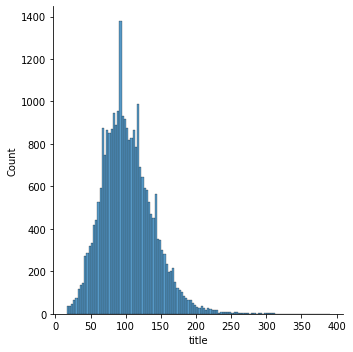

In [ ]:
# trainデータ文字数分布
title_len = train_df.title.str.len()
sns.displot(title_len)

"trainのtitle文字数: min={}, max={}, mean={:.2f}".format(
    title_len.min(), title_len.max(), title_len.mean())

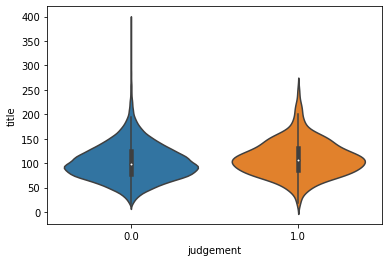

In [ ]:
# 正例、負例の文字数分布
sns.violinplot(x=train_df.judgement, y=title_len)

'testのtitle文字数: min=16, max=508, mean=102.55'

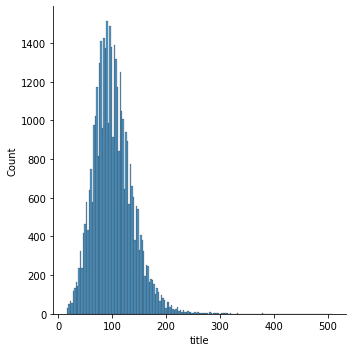

In [ ]:
# testデータ文字数分布
test_title_len = test_df.title.str.len()
sns.displot(test_title_len)

"testのtitle文字数: min={}, max={}, mean={:.2f}".format(
    test_title_len.min(), test_title_len.max(), test_title_len.mean())

***
単語数

'trainのtitle単語数: min=2, max=53, mean=13.60'

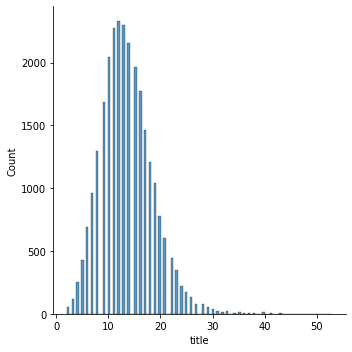

In [ ]:
# trainデータ単語数分布
title_num_words = train_df.title.str.split().map(lambda x: len(x))
sns.displot(title_num_words)

"trainのtitle単語数: min={}, max={}, mean={:.2f}".format(
    title_num_words.min(), title_num_words.max(), title_num_words.mean()
    )

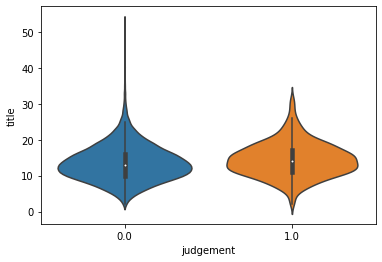

In [ ]:
# 正例、負例の単語数分布
sns.violinplot(x=train_df.judgement, y=title_num_words)

'testのtitle単語数: min=2, max=69, mean=13.57'

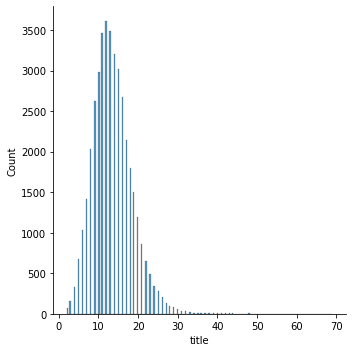

In [ ]:
# testデータ単語数分布
test_title_num_words = test_df.title.str.split().map(lambda x: len(x))
sns.displot(test_title_num_words)

"testのtitle単語数: min={}, max={}, mean={:.2f}".format(
    test_title_num_words.min(), 
    test_title_num_words.max(), 
    test_title_num_words.mean()
    )

***
語彙出現頻度

In [ ]:
# stopwordsのロード
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

def create_corpus(df: pd.Series):
    """
    stopwordsにない語彙のリストを返す
    """
    corpus = []
    for row in df.str.split():
        for word in row:
            if word.lower() not in stop_words:
                corpus.append(word.lower())
    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# trainデータ頻出語彙
title_corpus = create_corpus(train_df.title)
Counter(title_corpus).most_common(20)

[('covid-19', 7435),
 ('patients', 3273),
 ('disease', 3064),
 ("alzheimer's", 2682),
 ('sars-cov-2', 1874),
 ('disease.', 1670),
 ('study', 1521),
 ('coronavirus', 1428),
 ('pandemic', 1410),
 ('clinical', 1325),
 ('brain', 1248),
 ('imaging', 1220),
 ('case', 1112),
 ('cognitive', 1041),
 ('infection', 1036),
 ('amyloid', 1025),
 ('analysis', 871),
 ('using', 869),
 ('associated', 843),
 ('protein', 802)]

In [ ]:
# 負例の頻出語彙
j0_title_corpus = create_corpus(train_df[train_df.judgement==0].title)
Counter(j0_title_corpus).most_common(20)

[('covid-19', 7261),
 ('patients', 3173),
 ('disease', 2968),
 ("alzheimer's", 2646),
 ('sars-cov-2', 1700),
 ('disease.', 1659),
 ('study', 1478),
 ('pandemic', 1406),
 ('coronavirus', 1375),
 ('clinical', 1266),
 ('brain', 1237),
 ('imaging', 1201),
 ('case', 1104),
 ('cognitive', 1034),
 ('amyloid', 1022),
 ('infection', 1008),
 ('analysis', 850),
 ('associated', 838),
 ('using', 818),
 ('protein', 797)]

In [ ]:
# 正例の頻出語彙
j1_title_corpus = create_corpus(train_df[train_df.judgement==1].title)
Counter(j1_title_corpus).most_common(20)

[('sars-cov-2', 174),
 ('covid-19', 174),
 ('detection', 119),
 ('patients', 100),
 ('disease', 96),
 ('diagnosis', 91),
 ('dementia', 70),
 ('lewy', 67),
 ('clinical', 59),
 ('diagnostic', 59),
 ('evaluation', 57),
 ('rapid', 54),
 ('coronavirus', 53),
 ('using', 51),
 ('chest', 46),
 ('study', 43),
 ('test', 40),
 ('comparison', 40),
 ('performance', 38),
 ('testing', 37)]

In [ ]:
# testデータ頻出語彙
test_title_corpus = create_corpus(test_df.title)
Counter(test_title_corpus).most_common(20)

[('covid-19', 11167),
 ('patients', 5000),
 ('disease', 4804),
 ("alzheimer's", 3980),
 ('sars-cov-2', 2769),
 ('disease.', 2518),
 ('study', 2368),
 ('coronavirus', 2327),
 ('pandemic', 2309),
 ('clinical', 2020),
 ('imaging', 1903),
 ('brain', 1813),
 ('case', 1763),
 ('amyloid', 1533),
 ('infection', 1531),
 ('cognitive', 1525),
 ('analysis', 1309),
 ('using', 1247),
 ('protein', 1241),
 ('2019', 1239)]

### 5.4.3 abstract
abstractの文字数、単語数の分布を表示します。正例は全体の分布に似ているのに対し、負例は尖度が少し異なる分布が表れます。

***
**文字数**

'train abstract文字数: min=0, max=9672, mean=1250.24'

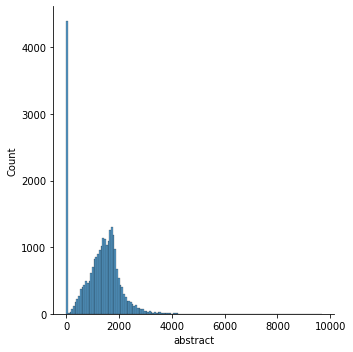

In [ ]:
# trainデータ文字数分布
abstract_len = train_df.abstract.str.len()
sns.displot(abstract_len)
"train abstract文字数: min={}, max={}, mean={:.2f}".format(
    abstract_len.min(),
    abstract_len.max(),
    abstract_len.mean()
)

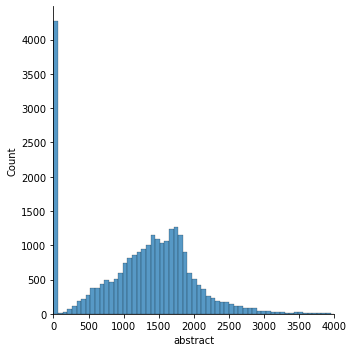

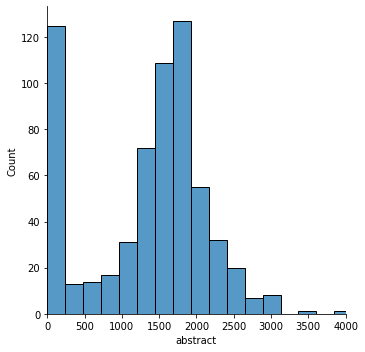

In [ ]:
# 正例、負例の文字数分布
sns.displot(abstract_len[train_df.judgement==0]).set(xlim=(0,4000))
sns.displot(abstract_len[train_df.judgement==1]).set(xlim=(0,4000))

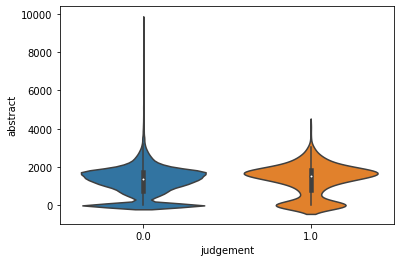

In [ ]:
sns.violinplot(x=train_df.judgement, y=abstract_len)

'test abstract文字数: min=0, max=12826, mean=1253.15'

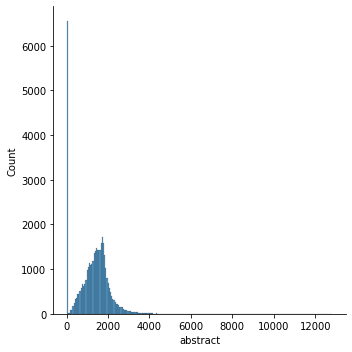

In [ ]:
# testデータ文字数分布
test_abstract_len = test_df.abstract.str.len()
sns.displot(test_abstract_len)
"test abstract文字数: min={}, max={}, mean={:.2f}".format(
    test_abstract_len.min(),
    test_abstract_len.max(),
    test_abstract_len.mean()
)

***
**単語数**

'trainのabstract単語数: min=0, max=1535, mean=180.84'

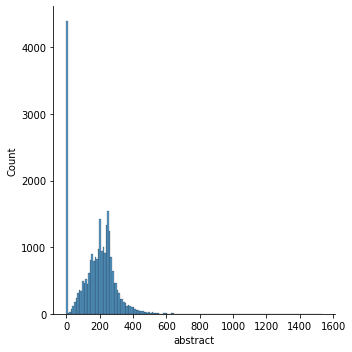

In [ ]:
# trainデータの単語数分布
abstract_num_words = train_df.abstract.str.split().map(lambda x: len(x))
sns.displot(abstract_num_words)

"trainのabstract単語数: min={}, max={}, mean={:.2f}".format(
    abstract_num_words.min(),
    abstract_num_words.max(), 
    abstract_num_words.mean()
    )

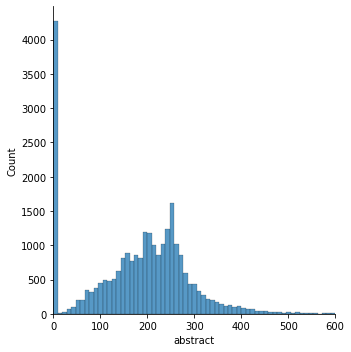

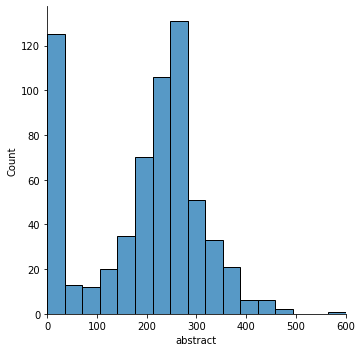

In [ ]:
# 正例、負例の単語数分布
sns.displot(abstract_num_words[train_df.judgement==0]).set(xlim=(0,600))
sns.displot(abstract_num_words[train_df.judgement==1]).set(xlim=(0,600))

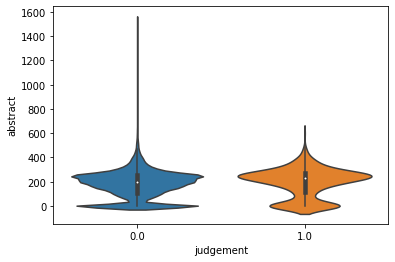

In [ ]:
sns.violinplot(x=train_df.judgement, y=abstract_num_words)

'testのabstract単語数: min=0, max=1445, mean=181.27'

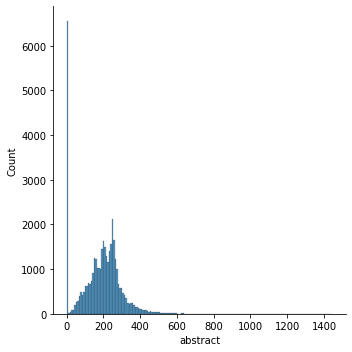

In [ ]:
# testデータの単語数分布
test_abstract_num_words = test_df.abstract.str.split().map(lambda x: len(x))
sns.displot(test_abstract_num_words)

"testのabstract単語数: min={}, max={}, mean={:.2f}".format(
    test_abstract_num_words.min(),
    test_abstract_num_words.max(), 
    test_abstract_num_words.mean()
    )

***
**頻出語彙**


In [ ]:
# trainデータ頻出語彙
abstract_corpus = create_corpus(train_df[train_df.judgement==0].abstract)
Counter(abstract_corpus).most_common(20)

[('patients', 36631),
 ('covid-19', 19645),
 ('disease', 18903),
 ('study', 11603),
 ('clinical', 10508),
 ('=', 9719),
 ('ad', 9523),
 ('may', 9412),
 ('brain', 9161),
 ('using', 8340),
 ('associated', 7879),
 ('data', 6970),
 ("alzheimer's", 6875),
 ('cases', 6833),
 ('compared', 6798),
 ('results', 6730),
 ('imaging', 6663),
 ('also', 6588),
 ('showed', 6537),
 ('risk', 6262)]

In [ ]:
# 負例頻出語彙
j0_abstract_corpus = create_corpus(train_df[train_df.judgement==0].abstract)
Counter(j0_title_corpus).most_common(20)

[('covid-19', 7261),
 ('patients', 3173),
 ('disease', 2968),
 ("alzheimer's", 2646),
 ('sars-cov-2', 1700),
 ('disease.', 1659),
 ('study', 1478),
 ('pandemic', 1406),
 ('coronavirus', 1375),
 ('clinical', 1266),
 ('brain', 1237),
 ('imaging', 1201),
 ('case', 1104),
 ('cognitive', 1034),
 ('amyloid', 1022),
 ('infection', 1008),
 ('analysis', 850),
 ('associated', 838),
 ('using', 818),
 ('protein', 797)]

In [ ]:
# 正例頻出語彙
j1_abstract_corpus = create_corpus(train_df[train_df.judgement==1].abstract)
Counter(j1_title_corpus).most_common(20)

[('sars-cov-2', 174),
 ('covid-19', 174),
 ('detection', 119),
 ('patients', 100),
 ('disease', 96),
 ('diagnosis', 91),
 ('dementia', 70),
 ('lewy', 67),
 ('clinical', 59),
 ('diagnostic', 59),
 ('evaluation', 57),
 ('rapid', 54),
 ('coronavirus', 53),
 ('using', 51),
 ('chest', 46),
 ('study', 43),
 ('test', 40),
 ('comparison', 40),
 ('performance', 38),
 ('testing', 37)]

In [ ]:
# testデータ頻出語彙
test_abstract_corpus = create_corpus(test_df.abstract)
Counter(test_abstract_corpus).most_common(20)

[('patients', 58310),
 ('covid-19', 31591),
 ('disease', 28884),
 ('study', 17802),
 ('clinical', 16712),
 ('ad', 14976),
 ('=', 14836),
 ('may', 14588),
 ('brain', 13266),
 ('using', 12908),
 ('associated', 12282),
 ('data', 10677),
 ('cases', 10530),
 ("alzheimer's", 10513),
 ('results', 10481),
 ('imaging', 10430),
 ('compared', 10230),
 ('also', 10213),
 ('results:', 9843),
 ('showed', 9825)]

### 5.4.4 text = title + abstract
titleとabstractの文字列を連結してtextという特徴量を作ります。<br>
このtextを各種BERTの入力として用いる予定です。<br>
大体のtoken数を見積もるため、単語数の分布を調べます。

In [ ]:
train_df.loc[:,"text"] = train_df.title + " " + train_df.abstract
test_df["text"] = test_df.title + " " + test_df.abstract

'text単語数: min=2, max=1537, mean=194.44, 512語以上のサンプル数=174'

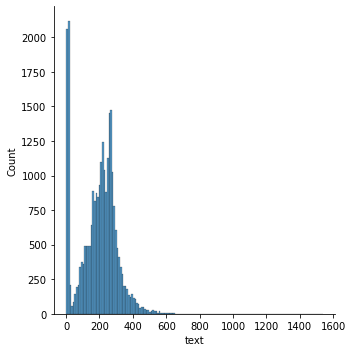

In [ ]:
# trainデータ
text_num_words = train_df.text.str.split().map(lambda x: len(x))
sns.displot(text_num_words)
"text単語数: min={}, max={}, mean={:.2f}, 512語以上のサンプル数={}".format(
    text_num_words.min(),
    text_num_words.max(),
    text_num_words.mean(),
    sum(text_num_words>512)
)

'text単語数: min=2, max=1457, mean=194.85, 512語以上のサンプル数=315'

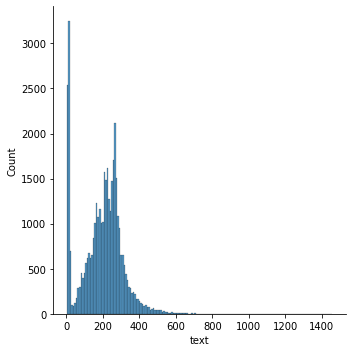

In [ ]:
# testデータ
test_text_num_words = test_df.text.str.split().map(lambda x: len(x))
sns.displot(test_text_num_words)
"text単語数: min={}, max={}, mean={:.2f}, 512語以上のサンプル数={}".format(
    test_text_num_words.min(),
    test_text_num_words.max(),
    test_text_num_words.mean(),
    sum(test_text_num_words>512)
)

## 5.5 データ保存
前処理したデータを保存します。

In [ ]:
train_df.iloc[:, :-1].to_csv(os.path.join(INPUT, "p_train.csv"), index=False)
test_df.iloc[:, :-1].to_csv(os.path.join(INPUT, "p_test.csv"), index=False)